# Object Detection with DETR - a minimal implementation

In this notebook we show a demo of DETR (Detection Transformer), with slight differences with the baseline model in the paper.

We show how to define the model, load pretrained weights and visualize bounding box and class predictions.

Let's start with some common imports.

In [ ]:
import os

# カレントディレクトリを変更
os.chdir('/')

# 現在のカレントディレクトリを確認
print("Current Directory:", os.getcwd())


In [2]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(True);

## DETR
Here is a minimal implementation of DETR:

このコードスニペットは，DETR（Detection Transformer）のデモ実装クラスである `DETRdemo` を定義しています．以下は主要な部分についての説明である：

1. **初期化 (`__init__` メソッド)**:
   - ResNet-50をバックボーンとしてセットアップ．
   - 2048次元から隠れ層の次元（デフォルトで256）への変換層を定義．
   - トランスフォーマーをセットアップ．
   - クラスラベルとバウンディングボックスの予測のための線形層を定義．
   - オブジェクトクエリと空間的な位置エンコーディングのためのパラメータを定義．

2. **順伝播 (`forward` メソッド)**:
   - 入力をResNet-50のバックボーンを通して特徴を抽出．
   - 抽出された特徴を変換層を通してトランスフォーマーの入力へ変換．
   - 位置エンコーディングの構築とトランスフォーマーを通しての伝播．
   - 最終的に，トランスフォーマーの出力をクラスラベルとバウンディングボックスに射影．

このクラスは，オブジェクト検出のためのモデルを定義し，入力画像からクラスラベルとバウンディングボックスの予測を行うために使用されます．特筆すべき違いとして，オリジナルのDETRと比べて，位置エンコーディングが学習される方式であり，位置エンコーディングが入力で渡される（注意ではなく），バウンディングボックスの予測が全結合層で行われる（MLPではなく）という点が挙げられます．

In [4]:
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)

        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h),
                'pred_boxes': self.linear_bbox(h).sigmoid(),
                'conv_features': x}

As you can see, DETR architecture is very simple, thanks to the representational power of the Transformer. There are two main components:
* a convolutional backbone - we use ResNet-50 in this demo
* a Transformer - we use the default PyTorch nn.Transformer


Let's construct the model with 80 COCO output classes + 1 ⦰ "no object" class and load the pretrained weights.
The weights are saved in half precision to save bandwidth without hurting model accuracy.

このセルのコードは，以下のステップでDETRデモモデルのインスタンスを作成し，学習済みの重みをロードして評価モードに設定しています：

1. **モデルのインスタンス作成**: `DETRdemo` クラスからインスタンスを作成し，91クラスのオブジェクト検出のためにセットアップしています．
2. **学習済みの重みのロード**: `torch.hub.load_state_dict_from_url` を使用して，指定されたURLから学習済みの重み（state_dict）をダウンロードし，ローカルのCPUにマップしています．
3. **重みのロード**: `detr.load_state_dict(state_dict)` を使用して，ダウンロードした重みをモデルにロードしています．
4. **評価モードの設定**: `detr.eval()` を呼び出すことで，モデルを評価モードに設定しています．これにより，学習中にのみ使用される特定の層（例：ドロップアウト層）が無効にされるため，評価時には一貫した予測が得られるようになります．

このセルは，事前学習済みのDETRモデルをセットアップし，その後の予測や評価に使用する準備をしている部分である．

In [5]:
detr = DETRdemo(num_classes=91)
detr.to(device)

state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location=device,
    check_hash=True)
detr.load_state_dict(state_dict)
detr.eval();

## Computing predictions with DETR

The pre-trained DETR model that we have just loaded has been trained on the 80 COCO classes, with class indices ranging from 1 to 90 (that's why we considered 91 classes in the model construction).
In the following cells, we define the mapping from class indices to names.

このセルでは，COCOデータセットのクラスラベルと視覚化に使用する色を定義しています．

1. **COCOクラス**: `CLASSES` 変数には，COCOデータセットで識別されるオブジェクトのクラス名のリストが格納されています．これにより，モデルの出力で得られるクラスインデックスを人間が理解できる名前にマッピングすることができます．
2. **視覚化の色**: `COLORS` 変数には，視覚化の際に使用する色のリストが格納されています．これらの色は，バウンディングボックスやその他の視覚化要素に使用されることが一般的です．

このセルは，モデルの予測結果を解釈し，視覚化するために必要な情報を提供する役割を果たしています．モデルが画像内のオブジェクトを検出した際，このセルで定義されたクラス名と色を使用して結果を表示することが可能になります．

In [8]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

DETR uses standard ImageNet normalization, and output boxes in relative image coordinates in $[x_{\text{center}}, y_{\text{center}}, w, h]$ format, where $[x_{\text{center}}, y_{\text{center}}]$ is the predicted center of the bounding box, and $w, h$ its width and height. Because the coordinates are relative to the image dimension and lies between $[0, 1]$, we convert predictions to absolute image coordinates and $[x_0, y_0, x_1, y_1]$ format for visualization purposes.

このセルでは，入力画像の前処理とバウンディングボックスの後処理に使用される変換と関数を定義しています．

1. **画像の前処理変換**:
   - `T.Resize(800)`: 画像を800ピクセルのサイズにリサイズ．
   - `T.ToTensor()`: PIL画像またはNumPy配列をPyTorchテンソルに変換．
   - `T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])`: 画像の正規化．平均と標準偏差を指定して，チャンネルごとに正規化．これらの値は，一般的に使用されるImageNetの統計に基づいています．

2. **バウンディングボックスの後処理関数**:
   - `box_cxcywh_to_xyxy(x)`: バウンディングボックスの形式を中心座標と幅・高さ（cx, cy, w, h）から左上と右下の座標（x_min, y_min, x_max, y_max）に変換．
   - `rescale_bboxes(out_bbox, size)`: バウンディングボックスを元の画像のサイズにリスケール．

これらの変換と関数は，モデルに入力する画像の準備と，モデルからの出力を解釈する際に使用されます．前処理変換は，モデルの訓練時に使用された同じ統計で画像を正規化するために必要です．バウンディングボックスの後処理関数は，モデルの予測結果を人間が理解できる形式に変換するために使用されます．

In [9]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

# def rescale_bboxes(out_bbox, size):
#     img_w, img_h = size
#     b = box_cxcywh_to_xyxy(out_bbox)
#     b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
#     return b
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    scale = torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to(out_bbox.device)  # デバイスを合わせる
    b = b * scale
    return b


Let's put everything together in a `detect` function:

このセルでは，画像に対してオブジェクト検出を実行するための `detect` 関数を定義しています．この関数は以下のステップで構成されています：

1. **画像の正規化**: 与えられた画像に対して，前述の`transform`で定義された前処理変換を適用し，バッチサイズ1でテンソルに変換します．
2. **画像サイズの検証**: このデモモデルは，各辺が最大1600ピクセルの画像をサポートしているため，サイズを検証しています．
3. **モデルの推論**: 正規化された画像をモデルに入力し，出力を取得します．出力にはクラスの対数確率（`pred_logits`）とバウンディングボックスの予測（`pred_boxes`）が含まれます．
4. **信頼度のしきい値**: 信頼度が0.7以上の予測のみを保持します．
5. **バウンディングボックスのリスケール**: 予測されたバウンディングボックスを画像の元のスケールにリスケールします．
6. **結果の返却**: 信頼度のしきい値を超えたクラスの確率，リスケールされたバウンディングボックス，および畳み込み特徴を返します．

この関数は，与えられた画像に対してオブジェクト検出を実行し，検出されたオブジェクトのクラスと位置を返すために使用されます．後続のコードでこの関数を使用すると，画像内のオブジェクトを識別し，その位置を特定することができます．

In [10]:
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0).to(device)  # 画像をGPUに移動

    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

     # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    print(outputs.keys())
    return probas[keep], bboxes_scaled, outputs['conv_features']

## Using DETR
To try DETRdemo model on your own image just change the URL below.

このセルのコードは，指定されたURLから画像をダウンロードし，以前に定義した`detect`関数を使用してオブジェクト検出を実行しています．具体的には以下のステップが行われています：

1. **画像のダウンロード**: `requests.get(url, stream=True).raw` を使用して指定されたURLから画像をストリームとしてダウンロードし，PILの`Image.open`を使用して画像として開きます．
2. **オブジェクトの検出**: `detect`関数を使用して，ダウンロードした画像に対してオブジェクト検出を実行します．この関数は以前に定義されたもので，`detr`モデルと`transform`前処理変換を使用しています．
3. **結果の抽出**: `detect`関数から返されたスコア（クラスの確率），バウンディングボックス，および畳み込み特徴を抽出します．
4. **特徴の形状の取得**: 畳み込み特徴の高さと幅を取得します．
5. **結果の形状の表示**: スコア，バウンディングボックス，特徴の形状を表示します．

このコードは，オンラインから画像を取得し，検出されたオブジェクトのクラスと位置について情報を提供する一連のプロセスを示しています．このプロセスは，Webアプリケーションなどでリアルタイムのオブジェクト検出を行う際の典型的なワークフローを反映しています．

In [11]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [12]:
def categorize_bbox_sizes(boxes, img_width, img_height):
    categories = []

    for box in boxes:
        # BBOXの幅と高さを計算
        width = box[2] - box[0]
        height = box[3] - box[1]

        # BBOXのサイズをピクセル単位で計算
        bbox_size = width * height

        # カテゴリを決定
        if bbox_size <= 10 * 10:
            category = 'Tiny'
        elif bbox_size < 32 * 32:
            category = 'Small'
        elif bbox_size < 96 * 96:
            category = 'Medium'
        else:
            category = 'Large'

        categories.append(category)

    return categories

# 使用例
# boxes = [[xmin, ymin, xmax, ymax], [xmin, ymin, xmax, ymax], ...]
# img_width, img_height = im.size
# categories = categorize_bbox_sizes(boxes, img_width, img_height)


### データセットの指定

In [ ]:
import os

# 指定されたディレクトリパス
directory_path = "/path/to/dataset"

# サポートされている画像フォーマットのリスト
image_formats = [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]

# ディレクトリ内の全ファイルをリストアップ
all_files = os.listdir(directory_path)

# 画像ファイルのみをフィルタリング
image_paths = [
    os.path.join(directory_path, file)
    for file in all_files
    if os.path.splitext(file)[1].lower() in image_formats
]

print(image_paths)

### 可視化

dict_keys(['pred_logits', 'pred_boxes', 'conv_features'])


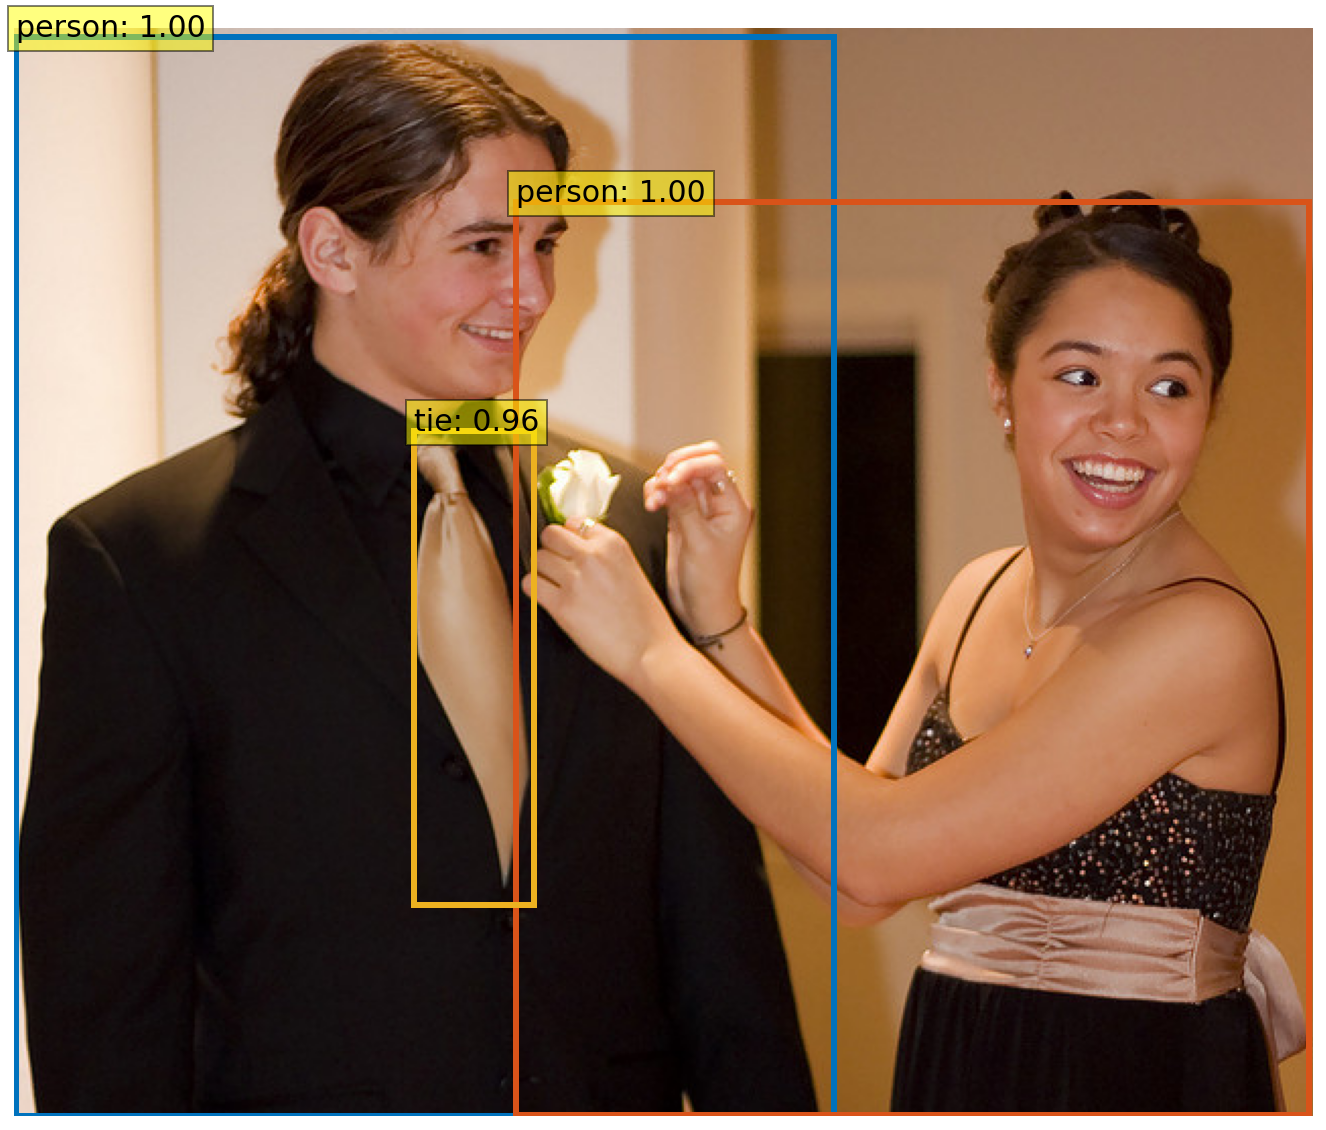

In [16]:
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import os
import cv2
import matplotlib.pyplot as plt

# Assuming 'detect', 'expand_boxes', 'plot_results', 'categorize_bbox_sizes', 'CLASSES', 'device', and 'transform' are defined


def apply_heatmap(image, heatmap, cmap, alpha=0.5):
    # Apply a heatmap to an image
    if not isinstance(image, np.ndarray):
        image = np.array(image)

    colored_heatmap = cmap(heatmap)[:, :, :3]  # Apply colormap and convert to RGB
    overlay = np.uint8(colored_heatmap * 255)  # Convert to uint8

    return np.clip(image * (1 - alpha) + overlay * alpha, 0, 255).astype(np.uint8)


for image_path in image_paths:
    im = Image.open(image_path)
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    output_directory = f"./{base_name}"
    os.makedirs(output_directory, exist_ok=True)
    img_width, img_height = im.size
    im_copy = np.asarray(im)
    H, W, _ = im_copy.shape
    resize = T.Resize((H, W))

    scores, boxes, features = detect(im, detr, transform)

    h, w = features.shape[-2:]
    odam_maps = torch.zeros((len(boxes), H, W)).to(device)
    fm = features
    tmp_maps = []

    for j, box in enumerate(boxes):
        coordinates = [box[0], box[1], -box[2], -box[3], scores[j, scores[j].argmax()]]
        maps = []

        for out in coordinates:
            grad = torch.autograd.grad(out, fm, retain_graph=True)[0]
            tmap = F.relu_((grad * fm).sum(1)).detach()
            tmap -= tmap.min()
            tmap /= tmap.max()
            maps.append(tmap)

        final_map = torch.max(
            torch.cat(maps, dim=0)
            * torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0])[:, None, None].to(tmap.device),
            dim=0,
        )[0]
        tmp_maps.append(final_map.unsqueeze(0))

    tmp_maps = torch.cat(tmp_maps, dim=0)
    tmp_maps = resize(tmp_maps)
    odam_maps += tmp_maps
    np.save(f"{output_directory}/odam_heatmap.npy", odam_maps.cpu().numpy())

    # 画像処理と保存
    for j, (xmin, ymin, xmax, ymax) in enumerate(boxes.detach().tolist()):

        class_id = scores[j].argmax()  # 最も高いスコアのクラスIDを取得
        class_name = CLASSES[class_id]  # クラスIDからクラス名を取得

        att = odam_maps[j]
        att_normalized = (att - att.min()) / (att.max() - att.min())
        att_normalized_np = att_normalized.cpu().numpy()

        # 注意マップを保存
        plt.axis("off")
        plt.imshow(att_normalized_np)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.savefig(
            f"{output_directory}/att_image_{j + 1}_{class_name}.png",
            bbox_inches="tight",
            pad_inches=0,
            dpi=150,
        )
        plt.clf()

        # カラーマップを保存
        att = att_normalized_np * 255.0
        color = cv2.applyColorMap(att.astype(np.uint8), cv2.COLORMAP_JET)[
            :, :, ::-1
        ]  # cv2 to plt
        if torch.is_tensor(im_copy):
            im_copy = im_copy.cpu().numpy()
        c_ret = np.clip(im_copy * (1 - 0.5) + color * 0.5, 0, 255).astype(np.uint8)
        plt.axis("off")
        plt.imshow(c_ret)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.savefig(
            f"{output_directory}/color_image_{j + 1}_{class_name}.png",
            bbox_inches="tight",
            pad_inches=0,
            dpi=150,
        )
        plt.clf()

        # バウンディングボックスを保存
        plt.imshow(im_copy)
        plt.gca().add_patch(
            plt.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                fill=False,
                color="red",
                linewidth=1,
            )
        )
        plt.axis("off")
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.savefig(
            f"{output_directory}/box_image_{j + 1}_{class_name}.png",
            bbox_inches="tight",
            pad_inches=0,
            dpi=150,
        )
        plt.clf()

        # 画像を読み込む
        box_img_path = f"{output_directory}/box_image_{j + 1}_{class_name}.png"
        color_img_path = f"{output_directory}/color_image_{j + 1}_{class_name}.png"
        att_img_path = f"{output_directory}/att_image_{j + 1}_{class_name}.png"

        box_img = Image.open(box_img_path)
        color_img = Image.open(color_img_path)
        att_img = Image.open(att_img_path)

        # 画像のサイズを取得
        box_img_width, box_img_height = box_img.size
        color_img_width, color_img_height = color_img.size
        att_img_width, att_img_height = att_img.size

        # 新しい画像のサイズを計算
        total_width = box_img_width + color_img_width + att_img_width
        max_height = max(box_img_height, color_img_height, att_img_height)

        # 新しい画像を作成
        combined_img = Image.new("RGB", (total_width, max_height))

        # 画像を新しい画像に貼り付ける
        combined_img.paste(box_img, (0, 0))
        combined_img.paste(color_img, (box_img_width, 0))
        combined_img.paste(att_img, (box_img_width + color_img_width, 0))

        # 結合した画像を保存
        combined_img.save(f"{output_directory}/combined_image_{j + 1}_{class_name}.png")

    plt.close()

    plot_results(im, scores, boxes)